In [1]:
# Load the librarys
import pandas as pd #To work with dataset
import numpy as np #Math library
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn

from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils import resample


# Importing the data
df_credit = pd.read_csv("./data/german_credit_data.csv", index_col=0)

## Preprocessing

In [2]:
# set age category
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
df_credit["Age_cat"] = pd.cut(df_credit.Age, interval, labels=cats)


df_good = df_credit[df_credit["Risk"] == 'good']
df_bad = df_credit[df_credit["Risk"] == 'bad']

df_credit['Saving accounts'] = df_credit['Saving accounts'].fillna('no_inf')
df_credit['Checking account'] = df_credit['Checking account'].fillna('no_inf')

# Purpose to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit.Purpose, drop_first=True, prefix='Purpose'), left_index=True, right_index=True)
# Sex feature in dummies
df_credit = df_credit.merge(pd.get_dummies(df_credit.Sex, drop_first=True, prefix='Sex'), left_index=True, right_index=True)
# Housing get dummies
df_credit = df_credit.merge(pd.get_dummies(df_credit.Housing, drop_first=True, prefix='Housing'), left_index=True, right_index=True)
# Housing get Saving Accounts
df_credit = df_credit.merge(pd.get_dummies(df_credit["Saving accounts"], drop_first=True, prefix='Savings'), left_index=True, right_index=True)
# Housing get Risk
df_credit = df_credit.merge(pd.get_dummies(df_credit.Risk, prefix='Risk'), left_index=True, right_index=True)
# Housing get Checking Account
df_credit = df_credit.merge(pd.get_dummies(df_credit["Checking account"], drop_first=True, prefix='Check'), left_index=True, right_index=True)
# Housing get Age categorical
df_credit = df_credit.merge(pd.get_dummies(df_credit["Age_cat"], drop_first=True, prefix='Age_cat'), left_index=True, right_index=True)

In [3]:
def one_hot_encoder(df, nan_as_category = False):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category, drop_first=True)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [4]:
print(pd.crosstab(df_credit["Checking account"],df_credit.Sex))

Sex               female  male
Checking account              
little                88   186
moderate              86   183
no_inf               116   278
rich                  20    43


In [5]:
# Excluding unused columns
del df_credit["Saving accounts"]
del df_credit["Checking account"]
del df_credit["Purpose"]
# del df_credit["Sex"]
del df_credit["Housing"]
# del df_credit["Age_cat"]
del df_credit["Risk"]
del df_credit['Risk_good']

In [6]:
# Transform string to integer
df_credit['Credit amount'] = np.log(df_credit['Credit amount'])
df_credit['Sex'].replace('female', 0,inplace=True)
df_credit['Sex'].replace('male', 1, inplace=True)

# set the age also to binary group
df_credit['Age_cat'].replace('Student', 0,inplace=True)
df_credit['Age_cat'].replace('Young', 0, inplace=True)
df_credit['Age_cat'].replace('Adult', 1, inplace=True)
df_credit['Age_cat'].replace('Senior', 1, inplace=True)

In [7]:
def get_training_result(df, show_fairness_measures = True):
    #Creating the X and y variables
    X = df.drop('Risk_bad', 1).values
    y = df["Risk_bad"].values

    # Spliting X and y into train and test version
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.36, random_state=42)

    # Criando o classificador logreg
    GNB = GaussianNB()

    # Fitting with train data
    model = GNB.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print("Accuracy: ", accuracy_score(y_test, y_pred))
    
    print("\n")
    print("Confusion matrix: ")

    print(confusion_matrix(y_test, y_pred))
    print("\n")
    print(classification_report(y_test, y_pred))

    #Predicting proba
    y_pred_prob = model.predict_proba(X_test)[:,1]

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    print("ROC_AUC: ", roc_auc_score(y_test, y_pred_prob))
    
    if show_fairness_measures:
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        print("Group fairness: ", (tp + fp) / (tp + fp + tn + fn))
        print("Separation with FPR: ", fp / (fp + tn))

Accuracy:  0.6527777777777778


Confusion matrix: 
[[175  75]
 [ 50  60]]


              precision    recall  f1-score   support

           0       0.78      0.70      0.74       250
           1       0.44      0.55      0.49       110

    accuracy                           0.65       360
   macro avg       0.61      0.62      0.61       360
weighted avg       0.68      0.65      0.66       360



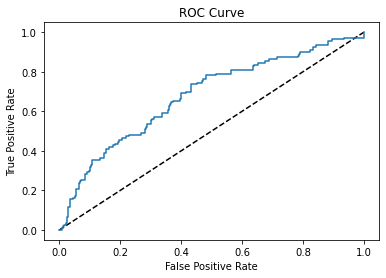

ROC_AUC:  0.6782545454545456
Group fairness:  0.375
Separation with FPR:  0.3


In [8]:
get_training_result(df_credit, True)

# Anti-classificaion

## Sex

Accuracy:  0.6472222222222223


Confusion matrix: 
[[177  73]
 [ 54  56]]


              precision    recall  f1-score   support

           0       0.77      0.71      0.74       250
           1       0.43      0.51      0.47       110

    accuracy                           0.65       360
   macro avg       0.60      0.61      0.60       360
weighted avg       0.66      0.65      0.65       360



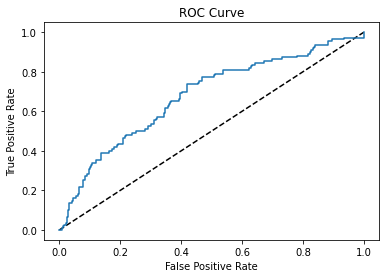

ROC_AUC:  0.6776


In [9]:
df_credit_without_sex = df_credit.copy()
del df_credit_without_sex['Sex']
get_training_result(df_credit_without_sex, False)

## Age

Accuracy:  0.6916666666666667


Confusion matrix: 
[[188  62]
 [ 49  61]]


              precision    recall  f1-score   support

           0       0.79      0.75      0.77       250
           1       0.50      0.55      0.52       110

    accuracy                           0.69       360
   macro avg       0.64      0.65      0.65       360
weighted avg       0.70      0.69      0.70       360



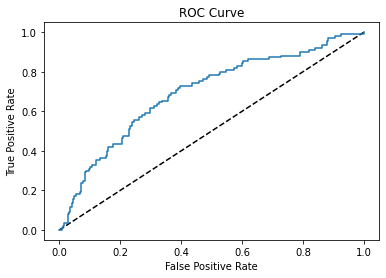

ROC_AUC:  0.6943272727272727


In [10]:
df_credit_without_age = df_credit.copy()
del df_credit_without_age['Age']
del df_credit_without_age['Age_cat']
del df_credit_without_age['Age_cat_Young']
del df_credit_without_age['Age_cat_Adult']
del df_credit_without_age['Age_cat_Senior']
get_training_result(df_credit_without_age, False)

# Group fairness and separation with FPR

## Sex

Accuracy:  0.44642857142857145


Confusion matrix: 
[[10 58]
 [ 4 40]]


              precision    recall  f1-score   support

           0       0.71      0.15      0.24        68
           1       0.41      0.91      0.56        44

    accuracy                           0.45       112
   macro avg       0.56      0.53      0.40       112
weighted avg       0.59      0.45      0.37       112



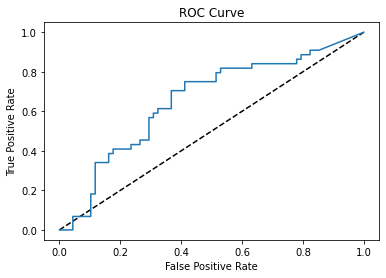

ROC_AUC:  0.6554144385026738
Group fairness:  0.875
Separation with FPR:  0.8529411764705882


In [11]:
# female
df_credit_female = df_credit[df_credit["Sex"] == 0]
get_training_result(df_credit_female)

Accuracy:  0.6666666666666666


Confusion matrix: 
[[128  60]
 [ 23  38]]


              precision    recall  f1-score   support

           0       0.85      0.68      0.76       188
           1       0.39      0.62      0.48        61

    accuracy                           0.67       249
   macro avg       0.62      0.65      0.62       249
weighted avg       0.74      0.67      0.69       249



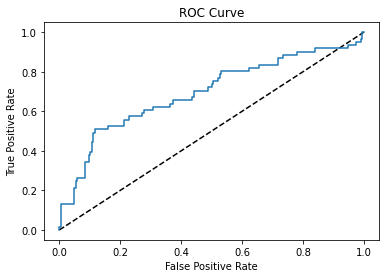

ROC_AUC:  0.6934949424485525
Group fairness:  0.39357429718875503
Separation with FPR:  0.3191489361702128


In [12]:
# male
df_credit_male = df_credit[df_credit["Sex"] == 1]
get_training_result(df_credit_male)

## Age

Accuracy:  0.6367924528301887


Confusion matrix: 
[[84 62]
 [15 51]]


              precision    recall  f1-score   support

           0       0.85      0.58      0.69       146
           1       0.45      0.77      0.57        66

    accuracy                           0.64       212
   macro avg       0.65      0.67      0.63       212
weighted avg       0.72      0.64      0.65       212



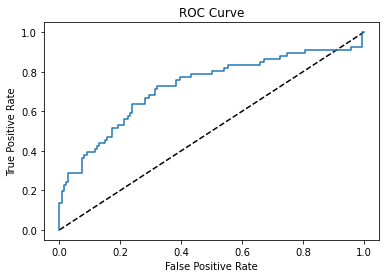

ROC_AUC:  0.7238480697384807
Group fairness:  0.5330188679245284
Separation with FPR:  0.4246575342465753


In [13]:
# young people

df_credit_young = df_credit[df_credit["Age_cat"] == 0]
get_training_result(df_credit_young)

Accuracy:  0.6912751677852349


Confusion matrix: 
[[80 28]
 [18 23]]


              precision    recall  f1-score   support

           0       0.82      0.74      0.78       108
           1       0.45      0.56      0.50        41

    accuracy                           0.69       149
   macro avg       0.63      0.65      0.64       149
weighted avg       0.72      0.69      0.70       149



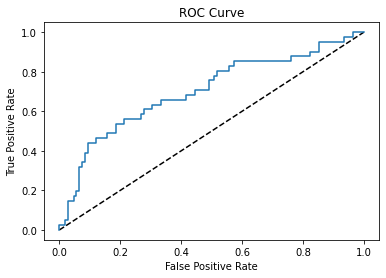

ROC_AUC:  0.7021228545618791
Group fairness:  0.3422818791946309
Separation with FPR:  0.25925925925925924


In [14]:
# old people

df_credit_old = df_credit[df_credit["Age_cat"] == 1]
get_training_result(df_credit_old)

# Improve fairness

## Adjusting threshold

### Sex

In [15]:
def adjust_threshold(df, threshold = 0.5):
    #Creating the X and y variables
    X = df.drop('Risk_bad', 1).values
    y = df["Risk_bad"].values

    # Spliting X and y into train and test version
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.36, random_state=42)

    # Criando o classificador logreg
    GNB = GaussianNB()

    # Fitting with train data
    model = GNB.fit(X_train, y_train)

    y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)

    #Predicting proba
    y_pred_prob = model.predict_proba(X_test)[:,1]

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("Group fairness: ", (tp + fp) / (tp + fp + tn + fn))

In [16]:
adjust_threshold(df_credit_male)

Accuracy:  0.6666666666666666
Group fairness:  0.39357429718875503


In [17]:
adjust_threshold(df_credit_male, 0.2)

Accuracy:  0.5622489959839357
Group fairness:  0.5381526104417671


In [18]:
adjust_threshold(df_credit_female)

Accuracy:  0.44642857142857145
Group fairness:  0.875


### Age

In [19]:
adjust_threshold(df_credit_old)

Accuracy:  0.6912751677852349
Group fairness:  0.3422818791946309


In [20]:
adjust_threshold(df_credit_old, 0.2)

Accuracy:  0.6644295302013423
Group fairness:  0.4228187919463087


In [21]:
adjust_threshold(df_credit_young)

Accuracy:  0.6367924528301887
Group fairness:  0.5330188679245284


## Separation

### Sex

In [22]:
def separation(df, show_fairness_measures = True):
    #Creating the X and y variables
    X = df.drop('Risk_bad', 1).values
    y = df["Risk_bad"].values

    # Spliting X and y into train and test version
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.36, random_state=42)

    # Criando o classificador logreg
    GNB = GaussianNB()

    # Fitting with train data
    model = GNB.fit(X_train, y_train)


    y_pred = model.predict(X_test)


    #Predicting proba
    y_pred_prob = model.predict_proba(X_test)[:,1]

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("Separation with FPR: ", fp / (fp + tn))

In [23]:
df_credit_append_female = df_credit.append(df_credit_female)

In [24]:
new_female = df_credit_append_female[df_credit_append_female["Sex"] == 0]

In [25]:
separation(new_female)

Accuracy:  0.6473214285714286
Separation with FPR:  0.4228187919463087


In [26]:
separation(df_credit_female)

Accuracy:  0.44642857142857145
Separation with FPR:  0.8529411764705882


In [27]:
separation(df_credit_male)

Accuracy:  0.6666666666666666
Separation with FPR:  0.3191489361702128


### Age

In [28]:
df_credit_append_young = df_credit.append(df_credit_young)

In [29]:
new_young = df_credit_append_young[df_credit_append_young["Age_cat"] == 0]

In [30]:
separation(new_young)

Accuracy:  0.6792452830188679
Separation with FPR:  0.3235294117647059


In [31]:
separation(df_credit_young)

Accuracy:  0.6367924528301887
Separation with FPR:  0.4246575342465753


In [32]:
separation(df_credit_old)

Accuracy:  0.6912751677852349
Separation with FPR:  0.25925925925925924
